<a href="https://colab.research.google.com/github/GeraldineQuispeT/Machine-Learning/blob/main/MLsklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
import random
import seaborn as sns
import pandas as pd
import librosa

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# 1. Data loading and feature extraction
def load_audio_data(folder_path, label):
    features = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".wav"):
            filepath = os.path.join(folder_path, filename)
            try:
                y, sr = librosa.load(filepath, sr=None) # Keeping original sampling rate

                # Feature 1: Energy
                energy = np.sum(y ** 2) / len(y)
                # Feature 2: Duration
                duration = len(y) / sr

                # Feature 3: Mean MFCC

                # Option A: Adjust n_mels (most common and effective fix)
                # If you have very low sample rates, you might need to go even lower for n_mels.
                n_mels_value = 80 # A good starting point, try 128 if this doesn't fully resolve
                mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_mels=n_mels_value)

                # Option B: Adjust fmax if you know your audio has no significant content
                #           above a certain frequency, AND you've also reduced n_mels
                #           accordingly. Be careful with this.
                # mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_mels=80, fmax=8000)

                mfccs_mean = np.mean(mfccs, axis=1)

                # Feature 4: Spectral centroid
                spec_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
                # Feature 5: Zero-crossing rate
                zcr = np.mean(librosa.feature.zero_crossing_rate(y))

                # Combine features (you can add/remove as needed)
                feature_vector = [energy, duration, spec_centroid, zcr] + list(mfccs_mean)

                if label is not None:
                    feature_vector.append(label)

                features.append(feature_vector)

            except Exception as e:
                print(f"Error processing {filepath}: {e}")
                # You might want to log this error or decide how to handle
                # files that fail to process (e.g., skip them or append None).
                continue # Skip to the next file

    return features

negative_path = 'cleaned_data/Negative'
positive_path = 'cleaned_data/Positive'
unknown_path  = 'cleaned_data/Unknown'

data_negative = load_audio_data(negative_path, 0)
data_positive = load_audio_data(positive_path, 1)
data = data_negative + data_positive
random.shuffle(data)

print("Number of features per sample:", len(data[0]))

FileNotFoundError: [Errno 2] No such file or directory: 'cleaned_data/Negative'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# X: all features except the last element (label)
X = np.array([d[:-1] for d in data])
# y: the last element (label)
y = np.array([d[-1] for d in data])

scaler = StandardScaler()
X = scaler.fit_transform(X)

# 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
print(X_train.shape, y_train.shape)

(1047, 17) (1047,)


In [ ]:
# 3. Define models and simplified hyperparameter grids
models = {
    "Logistic Regression": (
        LogisticRegression(max_iter=2000, solver='liblinear'),
        {
            'C': [0.0001, 0.001, 0.01, 0.1],
            'penalty': ['l1', 'l2']
        }
    ),
    "SVM": (
        SVC(),
        {
            'C': [0.01, 0.1, 1, 10,100],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        }
    ),
    "Decision Tree": (
        DecisionTreeClassifier(),
        {
            'max_depth': [i for i in range(1, 11)],
            'min_samples_split': [2, 10],
            'min_samples_leaf': [1, 4]
        }
    ),
    "KNN": (
        KNeighborsClassifier(),
        {
            'n_neighbors': [1,2,3, 5, 7],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]
        }
    )
}

# 4. Grid search with cross-validation
results = {}
best_estimators = {}


for name, (model, param_grid) in models.items():
    grid = GridSearchCV(model, param_grid, cv=5, scoring='recall', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_estimators[name] = grid.best_estimator_
    y_pred = grid.predict(X_test)
    results[name] = {
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'accuracy': accuracy_score(y_test, y_pred)
    }
    print(f"{name} best params: {grid.best_params_}")



Logistic Regression best params: {'C': 0.0001, 'penalty': 'l2'}
SVM best params: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Decision Tree best params: {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2}
KNN best params: {'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}


In [ ]:
from sklearn.model_selection import cross_val_score

print("=== K-Fold Cross-Validation Error Estimation ===")
for name, model in best_estimators.items():
    # Use recall as the main metric, change to 'f1' or others if needed
    scores = cross_val_score(model, X, y, cv=5, scoring='recall')
    print(f"{name}: Recall (mean ± std): {np.mean(scores):.3f} ± {np.std(scores):.3f}")

=== K-Fold Cross-Validation Error Estimation ===
Logistic Regression: Recall (mean ± std): 0.010 ± 0.020
SVM: Recall (mean ± std): 0.293 ± 0.130
Decision Tree: Recall (mean ± std): 0.216 ± 0.075
KNN: Recall (mean ± std): 0.344 ± 0.090


In [ ]:
from sklearn.utils import resample

print("=== Bootstrap Error Estimation ===")
n_bootstrap = 30
for name, model in best_estimators.items():
    recalls = []
    for i in range(n_bootstrap):
        X_bs, y_bs = resample(X, y, replace=True, random_state=42+i)
        model.fit(X_bs, y_bs)
        y_pred = model.predict(X)
        recalls.append(recall_score(y, y_pred, zero_division=0))
    print(f"{name}: Recall (mean ± std): {np.mean(recalls):.3f} ± {np.std(recalls):.3f}")

=== Bootstrap Error Estimation ===
Logistic Regression: Recall (mean ± std): 0.027 ± 0.026
SVM: Recall (mean ± std): 0.725 ± 0.042
Decision Tree: Recall (mean ± std): 0.408 ± 0.061
KNN: Recall (mean ± std): 0.740 ± 0.035


,Logistic Regression,SVM,Decision Tree,KNN
Precision,0.0,0.454545,0.400000,0.333333
Recall,0.0,0.250000,0.200000,0.250000
F1-score,0.0,0.322581,0.266667,0.285714



=== RECALL SCORES (Main Focus) ===
Logistic Regression: Recall = 0.000
SVM: Recall = 0.250
Decision Tree: Recall = 0.200
KNN: Recall = 0.250


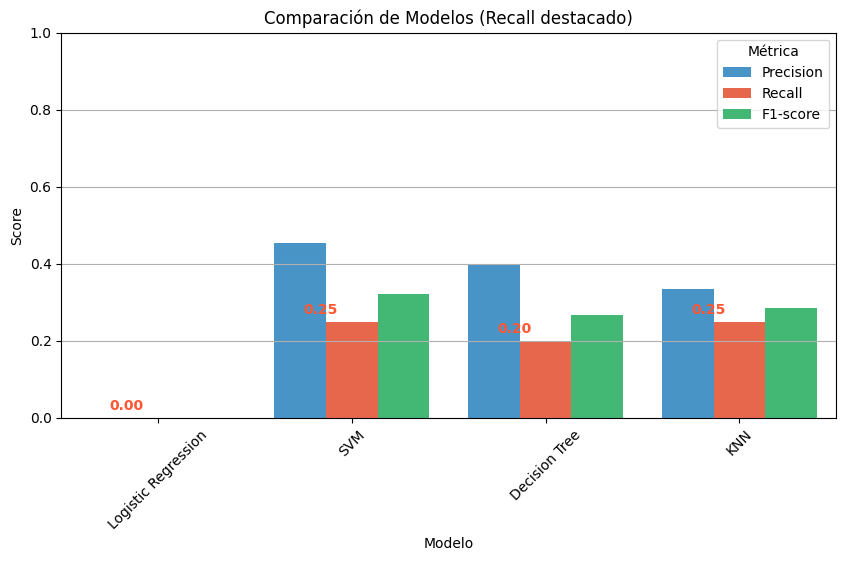

In [ ]:
# 5. Display results
metrics_df = pd.DataFrame({
    model: [results[model]['precision'], results[model]['recall'], results[model]['f1']]
    for model in results
}, index=['Precision', 'Recall', 'F1-score'])

display(metrics_df)

# Highlight recall in the printed output
print("\n=== RECALL SCORES (Main Focus) ===")
for model in results:
    print(f"{model}: Recall = {results[model]['recall']:.3f}")

# 6. Plot confusion matrices and highlight recall in the barplot
import matplotlib.patches as mpatches

metrics_long = metrics_df.T.reset_index().melt(id_vars='index', var_name='Métrica', value_name='Score')
metrics_long = metrics_long.rename(columns={'index': 'Modelo'})

plt.figure(figsize=(10,5))
palette = {'Recall': '#FF5733', 'Precision': '#3498DB', 'F1-score': '#2ECC71'}
sns.barplot(x='Modelo', y='Score', hue='Métrica', data=metrics_long, palette=palette)
plt.title("Comparación de Modelos (Recall destacado)")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y')

# Add annotation for recall bars
for i, model in enumerate(metrics_df.columns):
    recall = metrics_df.loc['Recall', model]
    plt.text(i-0.25, recall+0.02, f"{recall:.2f}", color='#FF5733', fontweight='bold')

plt.show()

In [ ]:
# 7. Predict on unknown data with best model (e.g., KNN)
unknown_data = load_audio_data(unknown_path, label=None)
X_unknown = np.array([d for d in unknown_data])  # Use all features
X_unknown = scaler.transform(X_unknown)
best_model = best_estimators["KNN"]
y_pred_unknown = best_model.predict(X_unknown)
print("Predicciones para datos desconocidos (0=Negativo, 1=Positivo):")
print(y_pred_unknown)

Predicciones para datos desconocidos (0=Negativo, 1=Positivo):
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0]
